# XGboost Prediction of TdF scores

[XGBoost](https://xgboost.readthedocs.io/en/latest/) implements the gradient boosting decision tree alogrithm. I choose this algorithm because I have heard good stories about this algorithm regarding to Kaggle competitions. In these stories, they praise the speed and performance of the algorithm. Therefore, I wanted to learn to use it. 

Boosting is an ensemble technique where new models are added to correct the errors made by the existing models. Since XGBoost is based on trees, the new models that are added are trees. And XGBoost adds one tree at a time. Then it uses gradient descent to minimize the loss when adding new models.

Note: Not all Tour de France teams have given up their team yet. Therefore, current predictions are made for 2019, which is also nice since it can be used to see if the model works properly.

In [1]:
# import
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [2]:
# Open up the features for each year in a dataframe and add it to a list so they can be concatenated.
feature_folder = 'features/'
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
df_files = ['features_' + str(year) + '.csv' for year in years]
features_dfs = []
for df_file in df_files:
    features_dfs.append(pd.read_csv(os.path.join(feature_folder, df_file), delimiter=';'))

In [3]:
features_dfs[5].head(5)

,Unnamed: 0,rider,PCS,Team,Age,Nationality,Team PCS,flat1-4,flat5-8,flat9-12,...,mountains(flat)1-4,mountains(flat)5-8,mountains(flat)9-12,mountains(uphill)1-4,mountains(uphill)5-8,mountains(uphill)9-12,gc1-4,gc5-8,gc9-12,wielerpoule
0,0,rider/christopher-froome,1377,Team Sky,29,Great Britain,4172,1.0,0.0,2.0,...,1.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0,1.0,7.0
1,1,rider/bernhard-eisel,185,Team Sky,33,Austria,4172,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,2,rider/vasil-kiryienka,417,Team Sky,33,Belarus,4172,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,10.0
3,3,rider/david-lopez,176,Team Sky,33,Spain,4172,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,4,rider/mikel-nieve,604,Team Sky,30,Spain,4172,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0


In [4]:
# Concatenate the dataframes and delete unwanted columns
data_df = pd.concat(features_dfs)
# Remove unnamed column
data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
# Remove rows that either have PCS, or age as None
data_df = data_df[data_df['PCS'] != 'None']
data_df = data_df[data_df['Age'] != 'None']
# Change datatypes
data_df = data_df.astype({"PCS": int, "Age": int})

## Normalize the wielerpoule score

In [5]:

def min_max_normalization(column):
   r""" Perform min-max normalization on given column.
       
        Min-max normalization is done to improve the convergence 
        of a machine learning model
       
        Returns
        -------
        normalized : pandas.DataFrame.column
           The min-max normalized pandas.DataFrame.column
        min_score : pandas Series or DataFrame
            Contains the minimum in the column
        max_score : pandas Series or DataFrame
            Contains the maximum in the column
            
        See Also
        --------
        pandas.DataFrame.min()
        pandas.DataFrame.max()
       
   """ 
  min_score = column.min()
  max_score = column.max()
  normalized = (column - min_score) / (max_score - min_score)
  return normalized, min_score, max_score

In [6]:
# Min-max the wielerpoule column which has to be predicted
data_df['wielerpoule'], min_score, max_score = min_max_normalization(data_df['wielerpoule'])

(array([1605.,  267.,   97.,   56.,   28.,   26.,   12.,    8.,    6.,
           3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

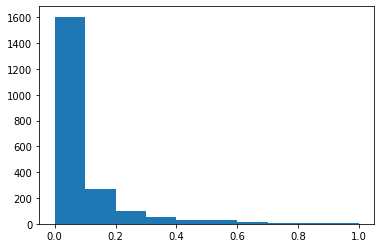

In [7]:
# Show normalized wielerpoule score in a histogram
plt.hist(data_df['wielerpoule'])

In [8]:
# Drop columns that are not used as features
columns_to_drop = ['rider', 'Team', 'Nationality']
cleaned_data_df = data_df.drop(columns_to_drop, axis=1).reset_index(drop=True)

# Divide the data in test (20%) and training (80%)
train_df = cleaned_data_df.sample(frac=0.8, random_state=420)
test_df = cleaned_data_df.drop(train_df.index)

In [9]:
train_df.head(5)

,PCS,Age,Team PCS,flat1-4,flat5-8,flat9-12,hills(flat)1-4,hills(flat)5-8,hills(flat)9-12,hills(uphill)1-4,...,mountains(flat)1-4,mountains(flat)5-8,mountains(flat)9-12,mountains(uphill)1-4,mountains(uphill)5-8,mountains(uphill)9-12,gc1-4,gc5-8,gc9-12,wielerpoule
2086,388,25,2853,1.0,0.0,0.0,0.0,3.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.000000
756,860,26,3953,5.0,1.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.489362
1712,46,38,2428,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1527,86,34,4578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
272,57,25,2403,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [10]:
test_df.head(5)

,PCS,Age,Team PCS,flat1-4,flat5-8,flat9-12,hills(flat)1-4,hills(flat)5-8,hills(flat)9-12,hills(uphill)1-4,...,mountains(flat)1-4,mountains(flat)5-8,mountains(flat)9-12,mountains(uphill)1-4,mountains(uphill)5-8,mountains(uphill)9-12,gc1-4,gc5-8,gc9-12,wielerpoule
2,249,29,4358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.035461
3,68,32,4358,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,1474,31,4358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
6,250,33,4358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
9,1824,32,3682,1.0,0.0,2.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0,0.156028


In [11]:
# Set up the labels
y_train = train_df['wielerpoule']
y_test = test_df['wielerpoule']

In [12]:
# Drop wielerpoule score as feature
train_df = train_df.drop('wielerpoule', axis=1)
test_df = test_df.drop('wielerpoule', axis=1)

In [13]:
# Quick check if data is split correctly
print(len(data_df))
print(len(train_df))
print(len(test_df))

2108
1686
422


In [14]:
# Load the data in a XGBoost datamatrix
dtrain = xgb.DMatrix(train_df, label=y_train)
dtest = xgb.DMatrix(test_df, label=y_test)

In [24]:
# specifity parameters via map, using the example generalized_linear_model
param = {'objective': 'reg:squarederror', 'booster':'gblinear', 'alpha': 0.0001,'lambda':1}
progress = dict()
num_round = 100
watchlist  = [(dtrain,'train-rmse'), (dtest, 'eval-rmse')]
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=progress)

[0]	train-rmse-rmse:0.17256	eval-rmse-rmse:0.17102
[1]	train-rmse-rmse:0.12771	eval-rmse-rmse:0.13233
[2]	train-rmse-rmse:0.11041	eval-rmse-rmse:0.11571
[3]	train-rmse-rmse:0.10348	eval-rmse-rmse:0.10882
[4]	train-rmse-rmse:0.09995	eval-rmse-rmse:0.10532
[5]	train-rmse-rmse:0.09766	eval-rmse-rmse:0.10287
[6]	train-rmse-rmse:0.09594	eval-rmse-rmse:0.10106
[7]	train-rmse-rmse:0.09465	eval-rmse-rmse:0.09965
[8]	train-rmse-rmse:0.09385	eval-rmse-rmse:0.09879
[9]	train-rmse-rmse:0.09296	eval-rmse-rmse:0.09772
[10]	train-rmse-rmse:0.09227	eval-rmse-rmse:0.09695
[11]	train-rmse-rmse:0.09173	eval-rmse-rmse:0.09632
[12]	train-rmse-rmse:0.09129	eval-rmse-rmse:0.09580
[13]	train-rmse-rmse:0.09092	eval-rmse-rmse:0.09535
[14]	train-rmse-rmse:0.09061	eval-rmse-rmse:0.09496
[15]	train-rmse-rmse:0.09035	eval-rmse-rmse:0.09463
[16]	train-rmse-rmse:0.09013	eval-rmse-rmse:0.09435
[17]	train-rmse-rmse:0.08993	eval-rmse-rmse:0.09410
[18]	train-rmse-rmse:0.08976	eval-rmse-rmse:0.09387
[19]	train-rmse-rmse:0

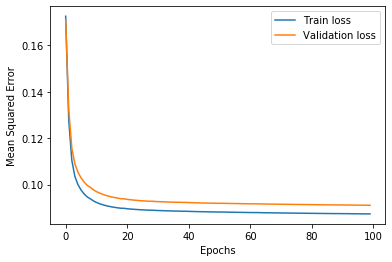

In [25]:
# Plot the train and validation loss
np_loss = np.asarray(progress['train']['rmse-rmse'])
np_val_loss = np.asarray(progress['eval']['rmse-rmse'])
plt.plot(np_loss, label='Train loss')
plt.plot(np_val_loss, label='Validation loss')
plt.legend()
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.show()

## Predict the 2020 scores


In [26]:
# Open features to predict
predict_filename = 'features/features_2020.csv'
predict_df = pd.read_csv(predict_filename, delimiter=';')
# Remove unnamed column
predict_df = predict_df.loc[:, ~predict_df.columns.str.contains('^Unnamed')]
# Change datatypes
predict_df = predict_df.astype({"PCS": int, "Age": int})

In [27]:
# Remove unwanted features
columns_to_drop = ['rider', 'Team', 'Nationality', 'wielerpoule']
cleaned_predict_df = predict_df.drop(columns_to_drop, axis=1)

In [28]:
# Add data to XGBoost datamatrix
dpredict = xgb.DMatrix(cleaned_predict_df)

In [29]:
# Predict the score
predictions = bst.predict(dpredict)

In [30]:
# reverse the normalization and add the predicted score to the dataframe
predict_df['predicted_score'] = predictions * (max_score - min_score) + min_score

In [31]:
# Sort the rows based on the predicted score
predict_df.sort_values(by='predicted_score', ascending=False)

,rider,PCS,Team,Age,Nationality,Team PCS,flat1-4,flat5-8,flat9-12,hills(flat)1-4,...,mountains(flat)5-8,mountains(flat)9-12,mountains(uphill)1-4,mountains(uphill)5-8,mountains(uphill)9-12,gc1-4,gc5-8,gc9-12,wielerpoule,predicted_score
12,rider/wout-van-aert,641,Team Jumbo-Visma,26,Belgium,1796,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.660540
23,rider/maximilian-schachmann,733,BORA - hansgrohe,26,Germany,1846,1.0,1.0,0.0,2.0,...,0.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,17.858335
152,rider/giacomo-nizzolo,577,NTT Pro Cycling,31,Italy,971,6.0,2.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.727863
104,rider/tadej-pogacar,682,UAE-Team Emirates,22,Slovenia,1476,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,2.0,1.0,3.0,0.0,0.0,0.0,16.525349
124,rider/caleb-ewan,385,Lotto Soudal,26,Australia,826,4.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.900551
13,rider/george-bennett,553,Team Jumbo-Visma,30,New Zealand,1796,1.0,0.0,0.0,3.0,...,0.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,12.881050
61,rider/daniel-felipe-martinez,421,EF Pro Cycling,24,Colombia,1364,2.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,11.376070
86,rider/jasper-stuyven,388,Trek - Segafredo,28,Belgium,1427,1.0,2.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.044475
101,rider/guillaume-martin,480,"Cofidis, Solutions Crédits",27,France,1033,1.0,0.0,0.0,1.0,...,1.0,0.0,4.0,3.0,1.0,1.0,2.0,1.0,0.0,9.695941
34,rider/sam-bennett,315,Deceuninck - Quick Step,30,Ireland,1587,4.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.669650
